In [1]:
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt

### Huffuman function

In [2]:
def huffuman_table_VLI(value, bit):
    if(value < 0):
        vli = int(value + (2**bit - 1))
        str_bit = '0' + str(bit) + 'b'
        vli_encode = format(vli, str_bit)
    else:
        vli = int(value)
        str_bit = '0' + str(bit) + 'b'
        vli_encode = format(vli, str_bit)

    return vli_encode

def inv_huffuman_VLI(str_vli):
    len1 = len(str_vli)
    vli_decode = 0
    for i in range(len1):
        vli_decode += (2**(len1-i-1)) * int(str_vli[i])
    
    if(str_vli[0] == '0'):
        vli_decode -= (2**(len1) - 1)
        
    return vli_decode
    

def huffuman_table_dc(mode, value): # mode = 0 for luminance, others for chorminance
    if(mode == 0):
        if(value == 0):
            encode = '00'
        elif(value == 1):
            encode = '010'
        elif(value == 2):
            encode = '011'
        elif(value == 3):
            encode = '100'
        elif(value == 4):
            encode = '101'
        elif(value == 5):
            encode = '110'
        elif(value >= 6):
            encode = (value - 5)*str(1) + '110'
    else:
        if(value <= 1):
            encode = format(value, '02b')
        else:
            encode = (value - 1)*str(1) + '0'
            
    return encode

def huffuman_table_ac(mode, array): # mode = 0 for luminance, others for chorminance
    # index = 0, 15; from 0 to 10
    # index = others; from 1 to 10
    table_lum = [['1010', '00', '01', '100', '1011', '11010', '1111000', '11111000', '1111110110', '1111111110000010', '1111111110000011'],
                 ['1100', '11011', '1111001', '111110110', '11111110110', '1111111110000100', '1111111110000101', '1111111110000110', '1111111110000111', '1111111110001000'],
                 ['11100', '11111001', '1111110111', '111111110100', '1111111110001001', '1111111110001010', '1111111110001011', '1111111110001100', '1111111110001101', '1111111110001110'],
                 ['111010', '111110111', '111111110101', '1111111110001111', '1111111110010000', '1111111110010001', '1111111110010010', '1111111110010011', '1111111110010100', '1111111110010101'],
                 ['111011', '1111111000', '1111111110010110', '1111111110010111', '1111111110011000', '1111111110011001', '1111111110011010', '1111111110011011', '1111111110011100', '1111111110011101'],
                 ['1111010', '11111110111', '1111111110011110', '1111111110011111', '1111111110100000', '1111111110100001', '1111111110100010', '1111111110100011', '1111111110100100', '1111111110100101'],
                 ['1111011', '111111110110', '1111111110100110', '1111111110100111', '1111111110101000', '1111111110101001', '1111111110101010', '1111111110101011', '1111111110101100', '1111111110101101'],
                 ['11111010', '111111110111', '1111111110101110', '1111111110101111', '1111111110110000', '1111111110110001', '1111111110110010', '1111111110110011', '1111111110110100', '1111111110110101'],
                 ['111111000', '111111111000000', '1111111110110110', '1111111110110111', '1111111110111000', '1111111110111001', '1111111110111010', '1111111110111011', '1111111110111100', '1111111110111101'],
                 ['111111001', '1111111110111110', '1111111110111111', '1111111111000000', '1111111111000001', '1111111111000010', '1111111111000011', '1111111111000100', '1111111111000101', '1111111111000110'],
                 ['111111010', '1111111111000111', '1111111111001000', '1111111111001001', '1111111111001010', '1111111111001011', '1111111111001100', '1111111111001101', '1111111111001110', '1111111111001111'],
                 ['1111111001', '1111111111010000', '1111111111010001', '1111111111010010', '1111111111010011', '1111111111010100', '1111111111010101', '1111111111010110', '1111111111010111', '1111111111011000'],
                 ['1111111010', '1111111111011001', '1111111111011010', '1111111111011011', '1111111111011100', '1111111111011101', '1111111111011110', '1111111111011111', '1111111111100000', '1111111111100001'],
                 ['11111111000', '1111111111100010', '1111111111100011', '1111111111100100', '1111111111100101', '1111111111100110', '1111111111100111', '1111111111101000', '1111111111101001', '1111111111101010'],
                 ['1111111111101011', '1111111111101100', '1111111111101101', '1111111111101110', '1111111111101111', '1111111111110000', '1111111111110001', '1111111111110010', '1111111111110011', '1111111111110100'],
                 ['11111111001', '1111111111110101', '1111111111110110', '1111111111110111', '1111111111111000', '1111111111111001', '1111111111111010', '1111111111111011', '1111111111111100', '1111111111111101', '1111111111111110']]
    table_chorm = [['00', '01', '100', '1010', '11000', '11001', '111000', '1111000', '111110100', '1111110110', '111111110100'],
                   ['1011', '111001', '11110110', '111110101', '11111110110', '111111110101', '1111111110001000', '1111111110001001', '1111111110001010', '1111111110001011'],
                   ['11010', '11110111', '1111110111', '111111110110', '111111111000010', '1111111110001100', '1111111110001101', '1111111110001110', '1111111110001111', '1111111110010000'],
                   ['11011', '11111000', '1111111000', '111111110111', '1111111110010001', '1111111110010010', '1111111110010011', '1111111110010100', '1111111110010101', '1111111110010110'],
                   ['111010', '111110110', '1111111110010111', '1111111110011000', '1111111110011001', '1111111110011010', '1111111110011011', '1111111110011100', '1111111110011101', '1111111110011110'],
                   ['111011', '1111111001', '1111111110011111', '1111111110100000', '1111111110100001', '1111111110100010', '1111111110100011', '1111111110100100', '1111111110100101', '1111111110100110'],
                   ['1111001', '11111110111', '1111111110100111', '1111111110101000', '1111111110101001', '1111111110101010', '1111111110101011', '1111111110101100', '1111111110101101', '1111111110101110'],
                   ['1111010', '11111111000', '1111111110101111', '1111111110110000', '1111111110110001', '1111111110110010', '1111111110110011', '1111111110110100', '1111111110110101', '1111111110110110'],
                   ['11111001', '1111111110110111', '1111111110111000', '1111111110111001', '1111111110111010', '1111111110111011', '1111111110111100', '1111111110111101', '1111111110111110', '1111111110111111'],
                   ['111110111', '1111111111000000', '1111111111000001', '1111111111000010', '1111111111000011', '1111111111000100', '1111111111000101', '1111111111000110', '1111111111000111', '1111111111001000'],
                   ['111111000', '1111111111001001', '1111111111001010', '1111111111001011', '1111111111001100', '1111111111001101', '1111111111001110', '1111111111001111', '1111111111010000', '1111111111010001'],
                   ['111111001', '1111111111010010', '1111111111010011', '1111111111010100', '1111111111010101', '1111111111010110', '1111111111010111', '1111111111011000', '1111111111011001', '1111111111011010'],
                   ['111111010', '1111111111011011', '1111111111011100', '1111111111011101', '1111111111011110', '1111111111011111', '1111111111100000', '1111111111100001', '1111111111100010', '1111111111100011'],
                   ['11111111001', '1111111111100100', '1111111111100101', '1111111111100110', '1111111111100111', '1111111111101000', '1111111111101001', '1111111111101010', '1111111111101011', '1111111111101100'],
                   ['11111111100000', '1111111111101101', '1111111111101110', '1111111111101111', '1111111111110000', '1111111111110001', '1111111111110010', '1111111111110011', '1111111111110100', '1111111111110101'],
                   ['1111111010', '111111111000011', '1111111111110110', '1111111111110111', '1111111111111000', '1111111111111001', '1111111111111010', '1111111111111011', '1111111111111100', '1111111111111101', '1111111111111110']]

    if(mode == 0):
        if(array[0] == 0 or array[0] == 15):
            str_out = table_lum[array[0]][array[1]]
        else:
            str_out = table_lum[array[0]][array[1] - 1]
    else:
        if(array[0] == 0 or array[0] == 15):
            str_out = table_chorm[array[0]][array[1]]
        else:
            str_out = table_chorm[array[0]][array[1] - 1]
    
    return str_out

### Huffuman LUT

In [3]:
huffuman_len_lut = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []
l7 = []
l8 = []
l9 = []
l10 = []
l11 = []
l12 = []
l13 = []
l14 = []
l15 = []
l16 = []

for i in range(16):
    if(i == 0) or (i == 15):
        list1 = range(11)
    else:
        list1 = range(1,11)

    for j in list1:
        str1 = huffuman_table_ac(0, [i, j])
        if(len(str1) == 2):
            l2.append([i, j])
        elif(len(str1) == 3):
            l3.append([i, j])      
        elif(len(str1) == 4):
            l4.append([i, j])
        elif(len(str1) == 5):
            l5.append([i, j])
        elif(len(str1) == 6):
            l6.append([i, j])
        elif(len(str1) == 7):
            l7.append([i, j])
        elif(len(str1) == 8):
            l8.append([i, j])
        elif(len(str1) == 9):
            l9.append([i, j])
        elif(len(str1) == 10):
            l10.append([i, j])
        elif(len(str1) == 11):
            l11.append([i, j])
        elif(len(str1) == 12):
            l12.append([i, j])
        elif(len(str1) == 13):
            l13.append([i, j])
        elif(len(str1) == 14):
            l14.append([i, j])
        elif(len(str1) == 15):
            l15.append([i, j])
        elif(len(str1) == 16):
            l16.append([i, j])
                
huffuman_len_lut = [l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14, l15, l16]

In [4]:
huffuman_ch_lut = []
ll2 = []
ll3 = []
ll4 = []
ll5 = []
ll6 = []
ll7 = []
ll8 = []
ll9 = []
ll10 = []
ll11 = []
ll12 = []
ll13 = []
ll14 = []
ll15 = []
ll16 = []

for i in range(16):
    if(i == 0) or (i == 15):
        list2 = range(11)
    else:
        list2 = range(1,11)

    for j in list2:
        str1 = huffuman_table_ac(1, [i, j])
        if(len(str1) == 2):
            ll2.append([i, j])
        elif(len(str1) == 3):
            ll3.append([i, j])      
        elif(len(str1) == 4):
            ll4.append([i, j])
        elif(len(str1) == 5):
            ll5.append([i, j])
        elif(len(str1) == 6):
            ll6.append([i, j])
        elif(len(str1) == 7):
            ll7.append([i, j])
        elif(len(str1) == 8):
            ll8.append([i, j])
        elif(len(str1) == 9):
            ll9.append([i, j])
        elif(len(str1) == 10):
            ll10.append([i, j])
        elif(len(str1) == 11):
            ll11.append([i, j])
        elif(len(str1) == 12):
            ll12.append([i, j])
        elif(len(str1) == 13):
            ll13.append([i, j])
        elif(len(str1) == 14):
            ll14.append([i, j])
        elif(len(str1) == 15):
            ll15.append([i, j])
        elif(len(str1) == 16):
            ll16.append([i, j])
                
huffuman_ch_lut = [ll2, ll3, ll4, ll5, ll6, ll7, ll8, ll9, ll10, ll11, ll12, ll13, ll14, ll15, ll16]

### Read File

In [5]:
num = input("Which size ?")
mode = input("Which mode ?")

if(num == '0'):
    path_folder = './img_96x64/'
    if(mode == '0'):
        path = './img_96x64/golden_96x64_411.txt'
    elif(mode == '1'):
        path = './img_96x64/golden_96x64_420.txt'
elif(num == '1'):
    path_folder = './img_91x61/'
    if(mode == '0'):
        path = './img_91x61/golden_91x61_411.txt'
    elif(mode == '1'):
        path = './img_91x61/golden_91x61_420.txt'
elif(num == '2'):
    path_folder = './img_800x600/'
    if(mode == '0'):
        path = './img_800x600/golden_800x600_411.txt'
    elif(mode == '1'):
        path = './img_800x600/golden_800x600_420.txt'
elif(num == '3'):
    path_folder = './img_1920x1280/'
    if(mode == '0'):
        path = './img_1920x1280/golden_1920x1280_411.txt'
    elif(mode == '1'):
        path = './img_1920x1280/golden_1920x1280_420.txt'
        
print("path_folder is %s"%path_folder)
print("data path is %s"%path)

Which size ?3
Which mode ?1
path_folder is ./img_1920x1280/
data path is ./img_1920x1280/golden_1920x1280_420.txt


In [6]:
f = open(path, 'r')
text = []
len1 = 0

for line in f.readlines():
    text.append(line)
    len1 += 1

print("Total Length : %d"%len1)

f.close()

Total Length : 531497


In [7]:
# size definition

if(num == '0'):
    W_org = 96
    H_org = 64
    W = 96
    H = 64
    if(mode == '0'):
        W_sub = 24
        H_sub = 64
    elif(mode == '1'):
        W_sub = 48
        H_sub = 32
elif(num == '1'):
    W_org = 91
    H_org = 61
    W = 96
    H = 64
    if(mode == '0'):
        W_sub = 24
        H_sub = 64
    elif(mode == '1'):
        W_sub = 48
        H_sub = 32
elif(num == '2'):
    W_org = 800
    H_org = 600
    W = 800
    H = 600
    if(mode == '0'):
        W_sub = 200
        H_sub = 600
    elif(mode == '1'):
        W_sub = 400
        H_sub = 304
elif(num == '3'):
    W_org = 1920
    H_org = 1280
    W = 1920
    H = 1280
    if(mode == '0'):
        W_sub = 480
        H_sub = 1280
    elif(mode == '1'):
        W_sub = 960
        H_sub = 640

print("H = %d"%H)
print("W = %d"%W)
print("H_org = %d"%H_org)
print("W_org = %d"%W_org)
print("H_sub = %d"%H_sub)
print("W_sub = %d"%W_sub)

H = 1280
W = 1920
H_org = 1280
W_org = 1920
H_sub = 640
W_sub = 960


In [8]:
# Amount of decode
quant_Y = W * H // 64
quant = W_sub * H_sub // 64

print("quant_Y = %d"%quant_Y)
print("quant = %d"%quant)

quant_Y = 38400
quant = 9600


In [9]:
if(mode == '0'):
    path4 = path_folder + 'len_y_411.txt'
    path5 = path_folder + 'len_u_411.txt'
    path6 = path_folder + 'len_v_411.txt'
elif(mode == '1'):
    path4 = path_folder + 'len_y_420.txt'
    path5 = path_folder + 'len_u_420.txt'
    path6 = path_folder + 'len_v_420.txt'

f4 = open(path4, 'r')
f5 = open(path5, 'r')
f6 = open(path6, 'r')

line_y = []
line_u = []
line_v = []

for line in f4.readlines():
    line_y.append(line)
for line in f5.readlines():
    line_u.append(line)
for line in f6.readlines():
    line_v.append(line)

ind = len(line_y) - 1
data = line_y[ind][0:len(line_y[ind])-1]
last_y = int(data)

ind = len(line_u) - 1
data = line_u[ind][0:len(line_u[ind])-1]
last_u = int(data) + last_y

ind = len(line_v) - 1
data = line_v[ind][0:len(line_v[ind])-1]
last_v = int(data) + last_u

print("line # of last Y : %d"%last_y)
print("line # of last U : %d"%last_u)
print("line # of last V : %d"%last_v)

f4.close()
f5.close()
f6.close()

line # of last Y : 468928
line # of last U : 504360
line # of last V : 531497


In [10]:
text1 = text[0:last_y]
text2 = text[last_y:last_u]
text3 = text[last_u:last_v]

len1 = len(text1)
len2 = len(text2)
len3 = len(text3)

print(len1)
print(len2)
print(len3)

468928
35432
27137


In [11]:
# remove '\n' character

y = np.zeros(quant_Y)
u = np.zeros(quant)
v = np.zeros(quant)

for i in range(len1):
    text1[i] = text1[i][0:len(text1[i])-1]
for i in range(len2):
    text2[i] = text2[i][0:len(text2[i])-1]
for i in range(len3):
    text3[i] = text3[i][0:len(text3[i])-1]
for i in range(quant_Y):
    line = line_y[i][0:len(line_y[i])-1]
    y[i] = int(line)
for i in range(quant):
    line = line_u[i][0:len(line_u[i])-1]
    u[i] = int(line)
for i in range(quant):
    line = line_v[i][0:len(line_v[i])-1]
    v[i] = int(line)
    
y = y.astype(int)
u = u.astype(int)
v = v.astype(int)

In [12]:
ly = np.zeros(quant_Y)
lu = np.zeros(quant)
lv = np.zeros(quant)

for i in range(quant_Y - 1, 0, -1):
    y[i] = y[i] - y[i-1]
for i in range(quant - 1, 0, -1):
    u[i] = u[i] - u[i-1]
    v[i] = v[i] - v[i-1]
y.shape

(38400,)

### Huffuman Decode (output : dc_value, ac_value)

In [13]:
# Decode for Y

done = 0
done1 = 0
len_array = 0
index = 0
cnt = 0
len_seek = 2
ac_new = []
ac_array = []
dc_array = []

ac_value_Y = []
dc_value_Y = []

for k in range(quant_Y):
    done1 = 0
    cnt += len_array
    len_array = y[k]
    ac_new = []
    ac_array = []
    dc_array = []
    index = 0
    while(done1 == 0):
        decode = huffuman_table_dc(0, index)
        if(text1[cnt][0:(len(decode))] == decode):
            done1 = 1
        else:
            index += 1

    if(huffuman_table_dc(0, index) != '00'):
        start = len(huffuman_table_dc(0, index))
        rest = text1[cnt][start:len(text1[cnt])]
        dc_decode = inv_huffuman_VLI(rest)
    elif(huffuman_table_dc(0, index) == '00'):
        dc_decode = 0

    dc_array.append(index)
    dc_array.append(int(dc_decode))
    dc_value_Y.append(dc_array)
    
    for i in range(len_array - 1):
        done = 0
        len_seek = 2
        while(done == 0 or (len_seek < len(text1[cnt+i+1]) - 1 and len_seek <= 16)):
            for j in range(len(huffuman_len_lut[len_seek - 2])):
                index_cmp = huffuman_len_lut[len_seek-2][j]
                str_cmp = huffuman_table_ac(0, index_cmp)
                if(text1[cnt+i+1][0:len_seek] == str_cmp):
                    ac_new.append(index_cmp)
                    done = 1
                    break
            len_seek += 1 

    for i in range(len_array - 1):
        if(ac_new[i] != [0,0]):
            start = len(huffuman_table_ac(0, ac_new[i]))
            rest = text1[cnt+i+1][start:len(text1[cnt+i+1])]
            if(ac_new[i] == [15,0] and start == len(text1[cnt+i+1])):
                ac_decode = 0
            else:
                ac_decode = inv_huffuman_VLI(rest)
            ac_array.append([ac_new[i][0], ac_new[i][1], ac_decode])
        elif(ac_new[i] == [0,0]):
            ac_array.append([ac_new[i][0], ac_new[i][1]])
            
    ac_value_Y.append(ac_array)

In [14]:
# Decode for U

done = 0
done1 = 0
len_array = 0
index = 0
cnt = 0
len_seek = 2
ac_new = []
ac_array = []
dc_array = []

ac_value_U = []
dc_value_U = []

for k in range(quant):
    done1 = 0
    cnt += len_array
    len_array = u[k]
    ac_new = []
    ac_array = []
    dc_array = []
    index = 0
    while(done1 == 0):
        decode = huffuman_table_dc(1, index)
        if(text2[cnt][0:(len(decode))] == decode):
            done1 = 1
        else:
            index += 1

    if(huffuman_table_dc(1, index) != '00'):
        start = len(huffuman_table_dc(1, index))
        rest = text2[cnt][start:len(text2[cnt])]
        dc_decode = inv_huffuman_VLI(rest)
    elif(huffuman_table_dc(1, index) == '00'):
        dc_decode = 0

    dc_array.append(index)
    dc_array.append(int(dc_decode))
    dc_value_U.append(dc_array)
    
    for i in range(len_array - 1):
        done = 0
        len_seek = 2
        while(done == 0 or (len_seek < len(text2[cnt+i+1]) - 1 and len_seek <= 16)):
            for j in range(len(huffuman_ch_lut[len_seek - 2])):
                index_cmp = huffuman_ch_lut[len_seek-2][j]
                str_cmp = huffuman_table_ac(1, index_cmp)
                if(text2[cnt+i+1][0:len_seek] == str_cmp):
                    ac_new.append(index_cmp)
                    done = 1
                    break
            len_seek += 1 
    
    for i in range(len_array - 1):
        if(ac_new[i] != [0,0]):
            start = len(huffuman_table_ac(1, ac_new[i]))
            rest = text2[cnt+i+1][start:len(text2[cnt+i+1])]
            if(ac_new[i] == [15,0] and start == len(text2[cnt+i+1])):
                ac_decode = 0
            else:
                ac_decode = inv_huffuman_VLI(rest)
            ac_array.append([ac_new[i][0], ac_new[i][1], ac_decode])
        elif(ac_new[i] == [0,0]):
            ac_array.append([ac_new[i][0], ac_new[i][1]])
            
    ac_value_U.append(ac_array)

In [15]:
# Decode for V

done = 0
done1 = 0
len_array = 0
index = 0
cnt = 0
len_seek = 2
ac_new = []
ac_array = []
dc_array = []

ac_value_V = []
dc_value_V = []

for k in range(quant):
    done1 = 0
    cnt += len_array
    len_array = v[k]
    ac_new = []
    ac_array = []
    dc_array = []
    index = 0

    while(done1 == 0):
        decode = huffuman_table_dc(1, index)
        if(text3[cnt][0:(len(decode))] == decode):
            done1 = 1
        else:
            index += 1

    if(huffuman_table_dc(1, index) != '00'):
        start = len(huffuman_table_dc(1, index))
        rest = text3[cnt][start:len(text3[cnt])]
        dc_decode = inv_huffuman_VLI(rest)
    elif(huffuman_table_dc(1, index) == '00'):
        dc_decode = 0

    dc_array.append(index)
    dc_array.append(int(dc_decode))
    dc_value_V.append(dc_array)
    
    for i in range(len_array - 1):
        done = 0
        len_seek = 2
        while(done == 0 or (len_seek < len(text3[cnt+i+1]) - 1 and len_seek <= 16)):
            for j in range(len(huffuman_ch_lut[len_seek - 2])):
                index_cmp = huffuman_ch_lut[len_seek-2][j]
                str_cmp = huffuman_table_ac(1, index_cmp)
                if(text3[cnt+i+1][0:len_seek] == str_cmp):
                    ac_new.append(index_cmp)
                    done = 1
                    break
            len_seek += 1 
    
    for i in range(len_array - 1):
        if(ac_new[i] != [0,0]):
            start = len(huffuman_table_ac(1, ac_new[i]))
            rest = text3[cnt+i+1][start:len(text3[cnt+i+1])]
            if(ac_new[i] == [15,0] and start == len(text3[cnt+i+1])):
                ac_decode = 0
            else:
                ac_decode = inv_huffuman_VLI(rest)
            ac_array.append([ac_new[i][0], ac_new[i][1], ac_decode])
        elif(ac_new[i] == [0,0]):
            ac_array.append([ac_new[i][0], ac_new[i][1]])
            
    ac_value_V.append(ac_array)

### Reconstruct 8x8 matrix

In [16]:
def index_calculator(smid, i, j, zero_num):

    while(zero_num > 0):
        if(smid < 8):
            if(smid % 2 == 1):
                diff = smid - i
                if(diff == 0):
                    zero_num -= 1
                    smid += 1
                    if(smid < 8):
                        i = smid
                    else:
                        i = 7
                        j = smid - 7
                elif(zero_num > diff):
                    zero_num -= (diff + 1)
                    smid += 1
                    j = 0
                    if(smid < 8):
                        i = smid
                    else:
                        i = 7
                        j = smid - 7
                elif(zero_num == diff):
                    zero_num = 0
                    j = 0
                    i = smid
                else:
                    j -= zero_num
                    i += zero_num
                    zero_num = 0 

            else:
                diff = smid - j
                if(diff == 0):
                    zero_num -= 1
                    smid += 1
                    if(smid < 8):
                        j = smid
                    else:
                        j = 7
                        i = smid - 7
                elif(zero_num > diff):
                    zero_num -= (diff + 1)
                    smid += 1
                    i = 0
                    if(smid < 8):
                        j = smid
                    else:
                        j = 7
                        i = smid - 7
                elif(zero_num == diff):
                    zero_num = 0
                    i = 0
                    j = smid
                else:
                    i -= zero_num                
                    j += zero_num
                    zero_num = 0 

        else:
            if(smid % 2 == 1):
                diff = 7 - i
                if(diff == 0):
                    zero_num -= 1
                    if(smid < 14):
                        smid += 1
                    else:
                        smid = 14
                    i = 7
                    j += 1
                elif(zero_num > diff):
                    zero_num -= (diff + 1)
                    if(smid < 14):
                        smid += 1
                    else:
                        smid = 14
                    j = smid - 7
                    i = 7                    
                elif(zero_num == diff):
                    zero_num -= diff 
                    j -= diff
                    i += diff
                else:
                    j -= zero_num
                    i += zero_num
                    zero_num = 0 

            else:
                diff = 7 - j
                if(diff == 0):
                    zero_num -= 1
                    if(smid < 14):
                        smid += 1
                    else:
                        smid = 14
                    j = 7
                    i += 1
                elif(zero_num > diff):
                    zero_num -= (diff + 1)
                    if(smid < 14):
                        smid += 1
                    else:
                        smid = 14
                    i = smid - 7
                    j = 7                    
                elif(zero_num == diff):
                    zero_num -= diff
                    i -= diff 
                    j += diff
                else:
                    i -= zero_num                
                    j += zero_num
                    zero_num = 0 

                    
    return smid, i, j

In [17]:
def reconstruct(dc_last, dc_array, ac_array):

    matrix_8x8 = np.zeros((8,8))

    sum_index = 1
    index_i = 0
    index_j = 0
    done = 0

    for i in range(len(ac_array)):
        if(index_i == 0 and index_j == 0):
            matrix_8x8[index_i][index_j] = dc_array[1] + dc_last
            index_j = 1
        if(ac_array[i] != [0,0]):
            if(ac_array[i][0] == 0):
                matrix_8x8[index_i][index_j] = ac_array[i][2]
                sum_index, index_i, index_j = index_calculator(sum_index, index_i, index_j, 1)
            else:
                zero_num = ac_array[i][0]
                sum_index, index_i, index_j = index_calculator(sum_index, index_i, index_j, zero_num)
                matrix_8x8[index_i][index_j] = ac_array[i][2]
                if(ac_array[i][2] == 0 and zero_num == 15) == False:
                    sum_index, index_i, index_j = index_calculator(sum_index, index_i, index_j, 1)

    return matrix_8x8

In [18]:
Y_quantize = np.zeros((H, W))
U_quantize = np.zeros((H_sub, W_sub))
V_quantize = np.zeros((H_sub, W_sub))

# Reconstruct Y
i = 0
j = 0

for k in range(quant_Y):
    if(k == 0):
        dc_last = 0
    else:
        dc_last += dc_value_Y[k-1][1]
    i = (k // (W // 8)) * 8
    j = (k % (W // 8)) * 8
    Y_quantize[i:i+8,j:j+8] = reconstruct(dc_last, dc_value_Y[k], ac_value_Y[k])

In [19]:
# Reconstruct U
i = 0
j = 0
dc_last = 0

for k in range(quant):
    if(k == 0):
        dc_last = 0
    else:
        dc_last += dc_value_U[k-1][1]
    i = (k // (W_sub // 8)) * 8
    j = (k % (W_sub // 8)) * 8
    U_quantize[i:i+8,j:j+8] = reconstruct(dc_last, dc_value_U[k], ac_value_U[k])

In [20]:
# Reconstruct V
i = 0
j = 0
dc_last = 0

for k in range(quant):
    if(k == 0):
        dc_last = 0
    else:
        dc_last += dc_value_V[k-1][1]
    i = (k // (W_sub // 8)) * 8
    j = (k % (W_sub // 8)) * 8
    V_quantize[i:i+8,j:j+8] = reconstruct(dc_last, dc_value_V[k], ac_value_V[k])

### Dequantize

In [21]:
lQtable_Y = [[0.0625, 0.08984375, 0.1015625, 0.0625, 0.04296875, 0.0234375, 0.01953125, 0.015625],
            [0.08203125, 0.08203125, 0.0703125, 0.05078125, 0.0390625, 0.015625, 0.015625, 0.01953125],
            [0.0703125, 0.078125, 0.0625, 0.04296875,  0.0234375, 0.015625, 0.015625, 0.01953125],
            [0.0703125, 0.05859375, 0.046875, 0.03515625, 0.01953125, 0.01171875, 0.01171875, 0.015625],
            [0.0546875,  0.046875, 0.02734375, 0.01953125, 0.015625, 0.0078125, 0.0078125, 0.01171875],
            [0.04296875, 0.02734375, 0.01953125, 0.015625, 0.01171875,  0.0078125,  0.0078125, 0.01171875],
            [0.01953125, 0.015625, 0.01171875, 0.01171875, 0.0078125, 0.0078125, 0.0078125, 0.01171875],
            [0.015625, 0.01171875, 0.01171875, 0.01171875, 0.0078125, 0.01171875, 0.0078125, 0.01171875]]

lQtable_UV = [[0.05859375, 0.0546875, 0.04296875, 0.01953125, 0.01171875, 0.01171875 ,0.01171875 ,0.01171875],
             [0.0546875, 0.046875, 0.0390625, 0.015625, 0.01171875, 0.01171875, 0.01171875, 0.01171875],
             [0.04296875, 0.0390625, 0.01953125, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875],
             [0.01953125, 0.015625, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875],
             [0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875],
             [0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875],
             [0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875],
             [0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875]]

table_Y = np.array(lQtable_Y)
table_UV = np.array(lQtable_UV)

Y_table_list = [[],[],[],[],[],[],[],[]]
UV_table_list = [[],[],[],[],[],[],[],[]]

for i in range(8):
    for j in range(8):
        Y_table_list[i].append(round(1 / table_Y[i][j]))
        
for i in range(8):
    for j in range(8):
        UV_table_list[i].append(round(1 / table_UV[i][j]))        

Qtable_Y = np.array(Y_table_list)
Qtable_UV = np.array(UV_table_list)

def Dequantize(input_8x8, mode, Qtable_Y, Qtable_UV):
    out = np.zeros((8,8))
    
    if(mode == 0):
        q_out = input_8x8 * Qtable_Y
        for i in range(8):
            for j in range(8):
                ff = round(q_out[i][j])
        
                if(q_out[i][j] < 0) and (ff < 0) and (ff - q_out[i][j] == -0.5):
                    ans = q_out[i][j] + 0.5
                elif(q_out[i][j] > 0) and (ff > 0) and (ff - q_out[i][j] == -0.5):
                    ans = q_out[i][j] + 0.5
                elif(q_out[i][j] == -0.5):
                    ans = 0
                elif(q_out[i][j] == 0.5):
                    ans = 1
                else:
                    ans = round(q_out[i][j])
                
                out[i][j] = ans
        
    else:
        q_out = input_8x8 * Qtable_UV
        for i in range(8):
            for j in range(8):
                ff = round(q_out[i][j])
        
                if(q_out[i][j] < 0) and (ff < 0) and (ff - q_out[i][j] == -0.5):
                    ans = q_out[i][j] + 0.5
                elif(q_out[i][j] > 0) and (ff > 0) and (ff - q_out[i][j] == -0.5):
                    ans = q_out[i][j] + 0.5
                elif(q_out[i][j] == -0.5):
                    ans = 0
                elif(q_out[i][j] == 0.5):
                    ans = 1
                else:
                    ans = round(q_out[i][j])
                
                out[i][j] = ans
        
    return q_out

In [22]:
Y_dequantize = np.zeros((H,W))
U_dequantize = np.zeros((H_sub,W_sub))
V_dequantize = np.zeros((H_sub,W_sub))

# Dequantize for Y
for i in range(0, H, 8):
    for j in range(0, W, 8):
        matrix = Y_quantize[i:i+8,j:j+8]
        Y_dequantize[i:i+8,j:j+8] = Dequantize(matrix, 0, Qtable_Y, Qtable_UV)
# Dequantize for U
for i in range(0, H_sub, 8):
    for j in range(0, W_sub, 8):
        matrix = U_quantize[i:i+8,j:j+8]
        U_dequantize[i:i+8,j:j+8] = Dequantize(matrix, 1, Qtable_Y, Qtable_UV)
# Dequantize for V
for i in range(0, H_sub, 8):
    for j in range(0, W_sub, 8):
        matrix = V_quantize[i:i+8,j:j+8]
        V_dequantize[i:i+8,j:j+8] = Dequantize(matrix, 2, Qtable_Y, Qtable_UV)

### IDCT

In [23]:
def DCT_1D(x):
    temp = np.zeros(8)
    X = np.zeros(8)
# Cosine table
    C = [1, 0.98046875, -0.92578125, 0.83203125, 0.70703125, -0.5546875, 0.3828125, 0.1953125] 
# DCT  

    n1 = x[0] * C[4]
    n2 = x[4] * C[4]
    n3 = -x[4] * C[4]
    n4 = x[2] * C[6]
    n5 = -x[2] * C[2]
    n6 = x[6] * C[2]
    n7 = x[6] * C[6]
    n8 = x[1] * C[7]
    n9 = x[1] * C[1]
    n10= x[5] * C[3]
    n11= -x[5] * C[5]
    n12= x[3] * C[5]
    n13= x[3] * C[3]
    n14= -x[7] * C[1]
    n15= x[7] * C[7]
    p0 = n1+n2+n5+n7
    p1 = n1+n3+n4+n6
    p2 = n1+n3-n4-n6
    p3 = n1+n2-n5-n7
    p4 = n8+n14+n10+n12
    p5 = n8+n14-n10-n12
    p6 = n15+n9-n13-n11
    p7 = n15+n9+n13+n11
    temp[0] = 0.5*(p0+p7)
    temp[1] = 0.5*(p1+p5*C[4]+p6*C[4])
    temp[2] = 0.5*(p2-p5*C[4]+p6*C[4])
    temp[3] = 0.5*(p3+p4)
    temp[4] = 0.5*(p3-p4)
    temp[5] = 0.5*(p2+p5*C[4]-p6*C[4])
    temp[6] = 0.5*(p1-p5*C[4]-p6*C[4])
    temp[7] = 0.5*(p0-p7)
    
    for i in range(8):
        ff = round(temp[i])
        if(temp[i] < 0) and (ff < 0) and (ff - temp[i] == -0.5):
            ans = temp[i] + 0.5
        elif(temp[i] > 0) and (ff > 0) and (ff - temp[i] == -0.5):
            ans = temp[i] + 0.5
        elif(temp[i] == -0.5):
            ans = 0
        elif(temp[i] == 0.5):
            ans = 1
        else:
            ans = round(temp[i])
            
        X[i] = ans
    
    return X

def IDCT_2D_8x8(input_8x8):
    x = np.zeros(8)
    X = np.zeros(8)
    MEM = np.zeros((8,8))
    MEM_final = np.zeros((8,8))
        
    for u in range(8):
        for k in range(8):
            x[k] = input_8x8[u][k]
            
        X = DCT_1D(x)
        
        for l in range(8):
            MEM[u][l] = X[l] 

    for v in range(8):                        
        for k in range(8):
            x[k] = MEM[k][v]
            
        X = DCT_1D(x)
    
        for l in range(8):
            MEM_final[l][v] = X[l]
            
    return MEM_final

In [24]:
Y_idct = np.zeros((H,W))
Y_test = np.zeros((H,W))
U_idct = np.zeros((H_sub,W_sub))
V_idct = np.zeros((H_sub,W_sub))

# IDCT for Y
for i in range(0, H, 8):
    for j in range(0, W, 8):
        matrix_idct = Y_dequantize[i:i+8, j:j+8]
        Y_idct[i:i+8,j:j+8] = IDCT_2D_8x8(matrix_idct)
# IDCT for U
for i in range(0, H_sub, 8):
    for j in range(0, W_sub, 8):
        matrix_idct = U_dequantize[i:i+8, j:j+8]
        U_idct[i:i+8,j:j+8] = IDCT_2D_8x8(matrix_idct)
# IDCT for V        
for i in range(0, H_sub, 8):
    for j in range(0, W_sub, 8):
        matrix_idct = V_dequantize[i:i+8, j:j+8]
        V_idct[i:i+8,j:j+8] = IDCT_2D_8x8(matrix_idct)

In [25]:
Y_idct_fix = np.zeros((H,W))
U_idct_fix = np.zeros((H_sub,W_sub))
V_idct_fix = np.zeros((H_sub,W_sub))


for i in range(H):
    for j in range(W):
        Y_idct_fix[i][j] = round(Y_idct[i][j])
        
for i in range(H_sub):
    for j in range(W_sub):
        U_idct_fix[i][j] = round(U_idct[i][j])
        V_idct_fix[i][j] = round(V_idct[i][j])

### expand UV for 411 and test pattern generate

In [138]:
H_fix = H_org 
W_fix = (W_org + 3) // 4 

U_re = np.zeros((H_fix,W_fix))
V_re = np.zeros((H_fix,W_fix))

for i in range(H_fix):
    for j in range(W_fix):
        U_re[i][j] = U_idct_fix[i][j]
        V_re[i][j] = V_idct_fix[i][j]
print(U_re.shape)

(64, 24)


In [139]:
Y = np.zeros((H_org,W_org))
U = np.zeros((H_org,W_org))
V = np.zeros((H_org,W_org))

for i in range(H_org):
    for j in range(W_org):
        Y[i][j] = Y_idct_fix[i][j]


for i in range(H_org):
    for j in range(W_org):
        U[i][j] = U_re[i][j // 4]
        V[i][j] = V_re[i][j // 4]


In [140]:
Y = Y.astype(int)
U_re = U_re.astype(int)
V_re = V_re.astype(int)

In [142]:
path1 = 'decode_Y_96x64_411.txt'
path2 = 'decode_U_96x64_411.txt'
path3 = 'decode_V_96x64_411.txt'

f1 = open(path1, 'w')
f2 = open(path2, 'w')
f3 = open(path3, 'w')


for i in range(H_org):
    for j in range(W_org):
        if(Y[i][j] < 0):
            data = Y[i][j] + 2**8
        else:
            data = Y[i][j]
        f1.write("%02x"%data)
        f1.write("\n")

for i in range(H_fix):
    for j in range(W_fix):
        if(U_re[i][j] < 0):
            data = U_re[i][j] + 2**8
        else:
            data = U_re[i][j]
        f2.write("%02x"%data)
        f2.write("\n")
for i in range(H_fix):
    for j in range(W_fix):
        if(V_re[i][j] < 0):
            data = V_re[i][j] + 2**8
        else:
            data = V_re[i][j]
        f3.write("%02x"%data)
        f3.write("\n")
f1.close()
f2.close()
f3.close()

In [39]:
Y = np.zeros((H_org,W_org))
U = np.zeros((H_org,W_org))
V = np.zeros((H_org,W_org))

for i in range(H_org):
    for j in range(W_org):
        Y[i][j] = Y_idct_fix[i][j] + 128


for i in range(H_org):
    for j in range(W_org):
        U[i][j] = U_re[i][j // 4]
        V[i][j] = V_re[i][j // 4]

### expand UV for 420 and test pattern generate

In [26]:
H_fix = (H_org + 1) // 2
W_fix = (W_org + 1) // 2 

U_re = np.zeros((H_fix,W_fix))
V_re = np.zeros((H_fix,W_fix))

for i in range(H_fix):
    for j in range(W_fix):
        U_re[i][j] = U_idct_fix[i][j]
        V_re[i][j] = V_idct_fix[i][j]

In [176]:
Y = np.zeros((H_org,W_org))
U = np.zeros((H_org,W_org))
V = np.zeros((H_org,W_org))

for i in range(H_org):
    for j in range(W_org):
        Y[i][j] = Y_idct_fix[i][j]
        
for i in range(H_org):
    for j in range(W_org):
        U[i][j] = U_re[i // 2][j // 2]
        V[i][j] = V_re[i // 2][j // 2]

In [177]:
Y = Y.astype(int)
U_re = U_re.astype(int)
V_re = V_re.astype(int)

In [178]:
path1 = 'decode_Y_96x64_420.txt'
path2 = 'decode_U_96x64_420.txt'
path3 = 'decode_V_96x64_420.txt'

f1 = open(path1, 'w')
f2 = open(path2, 'w')
f3 = open(path3, 'w')


for i in range(H_org):
    for j in range(W_org):
        if(Y[i][j] < 0):
            data = Y[i][j] + 2**8
        else:
            data = Y[i][j]
        f1.write("%02x"%data)
        f1.write("\n")

for i in range(H_fix):
    for j in range(W_fix):
        if(U_re[i][j] < 0):
            data = U_re[i][j] + 2**8
        else:
            data = U_re[i][j]
        f2.write("%02x"%data)
        f2.write("\n")
for i in range(H_fix):
    for j in range(W_fix):
        if(V_re[i][j] < 0):
            data = V_re[i][j] + 2**8
        else:
            data = V_re[i][j]
        f3.write("%02x"%data)
        f3.write("\n")
f1.close()
f2.close()
f3.close()

In [27]:
Y = np.zeros((H_org,W_org))
U = np.zeros((H_org,W_org))
V = np.zeros((H_org,W_org))

for i in range(H_org):
    for j in range(W_org):
        Y[i][j] = Y_idct_fix[i][j] + 128
        
for i in range(H_org):
    for j in range(W_org):
        U[i][j] = U_re[i // 2][j // 2]
        V[i][j] = V_re[i // 2][j // 2]

### YUV to RGB

In [28]:
def YUV2RGB(Y, U, V, width, height):
    R = np.zeros((height, width))
    G = np.zeros((height, width))
    B = np.zeros((height, width))    
    
    for i in range(height):
        for j in range(width):
            data1 = Y[i][j] + 1.402 * V[i][j]
            data2 = Y[i][j] - 0.34414 * U[i][j] - 0.71414 * V[i][j]
            data3 = Y[i][j] + 1.722 * U[i][j]
            
            
            ff1 = round(data1)
            if(ff1 < 0) and (data1 < 0) and (ff1 - data1 == -0.5):
                ans1 = data1 + 0.5
            elif(ff1 > 0) and (data1 > 0) and (ff1 - data1 == -0.5):
                ans1 = data1 + 0.5
            elif(data1 == -0.5):
                ans1 = 0
            elif(data1 == 0.5):
                ans1 = 1
            else:
                ans1 = round(data1)

            ff2 = round(data2)
            if(ff2 < 0) and (data2 < 0) and (ff2 - data2 == -0.5):
                ans2 = data2 + 0.5
            elif(ff2 > 0) and (data2 > 0) and (ff2 - data2 == -0.5):
                ans2 = data2 + 0.5
            elif(data2 == -0.5):
                ans2 = 0
            elif(data2 == 0.5):
                ans2 = 1
            else:
                ans2 = round(data2)

            ff3 = round(data3)
            if(ff3 < 0) and (data3 < 0) and (ff3 - data3 == -0.5):
                ans3 = data3 + 0.5
            elif(ff3 > 0) and (data3 > 0) and (ff3 - data3 == -0.5):
                ans3 = data3 + 0.5
            elif(data3 == -0.5):
                ans3 = 0
            elif(data3 == 0.5):
                ans3 = 1
            else:
                ans3 = round(data3)
                
            R[i][j] = ans1
            G[i][j] = ans2
            B[i][j] = ans3
        
    return R, G, B


In [29]:
R, G, B = YUV2RGB(Y, U, V, W_org, H_org)

### Reconstruct Picture

In [30]:
img = np.zeros((H_org,W_org,3))

for i in range(H_org):
    for j in range(W_org):
        img[i][j][0] = R[i][j]
        img[i][j][1] = G[i][j]
        img[i][j][2] = B[i][j]
        
img = img.astype(int)

### Output reconstructed picture

In [31]:
img_bgr = np.zeros((H,W,3))

for i in range(H):
    for j in range(W):
        img_bgr[i][j][2] = R[i][j]
        img_bgr[i][j][1] = G[i][j]
        img_bgr[i][j][0] = B[i][j]

In [32]:
cv2.imwrite('re_img_1920x1280.bmp', img_bgr)

True

### reconstructed image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


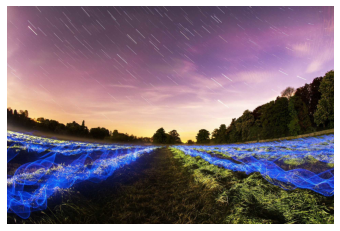

In [33]:
plt.imshow(img) 
plt.axis('off') 
plt.show()

### original image

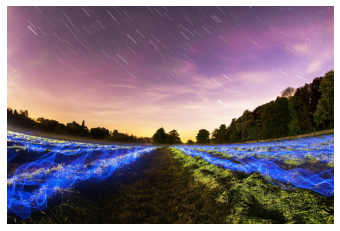

In [34]:
from PIL import Image

img_org = np.array(Image.open('sample_1920x1280.bmp'))

plt.imshow(img_org) 
plt.axis('off') 
plt.show()